In [57]:
%ls

14090.gro            run_171_dists.dat  run_174_dists.dat  run_177_dists.dat
mbar_test_VAV.ipynb  run_172_dists.dat  run_175_dists.dat  run_178_dists.dat
run_170_dists.dat    run_173_dists.dat  run_176_dists.dat  run_179_dists.dat


In [14]:
import os, sys, glob, tqdm
import numpy as np
import mdtraj as md
from pymbar import MBAR
from pymbar import timeseries

print(os.getcwd())
# denote run indices
run_indices = range(20)
# these runs represent the ensembles: lam = false, d = {0.1, 2.0, 0.1}

# denote number of ensembles
K = len(run_indices)
L = K

# kspring_k is the harmonic potential spring constant (in kJ/mol/nm^2) for eack ensemble
kspring_k = [200.0] * K

# Keep track of WHAT distance(s) is/are being restrained in each ensemble
restrained_distance_indices = [[[555,'COM']]]*K
restrained_distance_labels = ['d555-ligand_COM']*K

# For this analysis, we will use only the 300K data
temperature = 300.0 # in K

# T_k is the temperature of each of the K ensembles
T_k = np.ones(K,float)*temperature

# beta is the inverse temperatures of each ensemble
kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))


/home/tug27224/projects/FEP


In [4]:
# this is useful for umbrella simulations that use COM of ligand as 
# restraint point instead of a single atom.

def compute_center_of_mass(traj, atom_indices=None):
    """Compute the center of mass for each frame.
    Parameters
    ----------
    traj : Trajectory
        Trajectory to compute center of mass for
    atom_indices : list of int
        Atoms to compute center of mass for. If None,
        will compute over all atoms
    Returns
    -------
    com : np.ndarray, shape=(n_frames, 3)
         Coordinates of the center of mass for each frame
    """

    if atom_indices is None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)

    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in traj.top.atoms])
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()

    #for i, x in enumerate(traj.xyz):
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

In [11]:
PROJid = '14101'
path = '/media/tug27224/methuselah1/new1/TRAJECTORIES/PROJ%s'%PROJid
custom_residues = ['1MQ','20Q','20U','I18','I31','NUT','YIN','K23']
custom_residues += ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A']

for run in range(len(run_indices)):
    distances = []
    f = open('run_%d_dists.dat'%run_indices[run],'a')
    f.write('#clone\ttime(ns)\t%s\n'%restrained_distance_labels[run])
    
    traj_files = sorted(glob.glob(path + '/P%s_R%d_*'%(PROJid,run_indices[run])))
    
    for j in tqdm.tqdm_notebook(range(len(traj_files))):
        traj = md.load(traj_files[j], top='%s.gro'%PROJid)
        ligand_indices = [a.index for a in traj.topology.atoms if a.residue.name in custom_residues]
        ligand_COM = compute_center_of_mass(traj,ligand_indices)
        protein_xyz = np.take(traj.xyz, [555], axis=1)

        for k in range(len(traj)):
            distance = np.sqrt((ligand_COM[k][0] - protein_xyz[k][0][0])**2 +
                                (ligand_COM[k][1] - protein_xyz[k][0][1])**2 +
                                (ligand_COM[k][2] - protein_xyz[k][0][2])**2)
            
            f.write('%d\t%f\t%f\n'%(j,0.1+ 0.1*k,distance))
    f.close()
    

## Step 1.  Let's look at the raw distance data

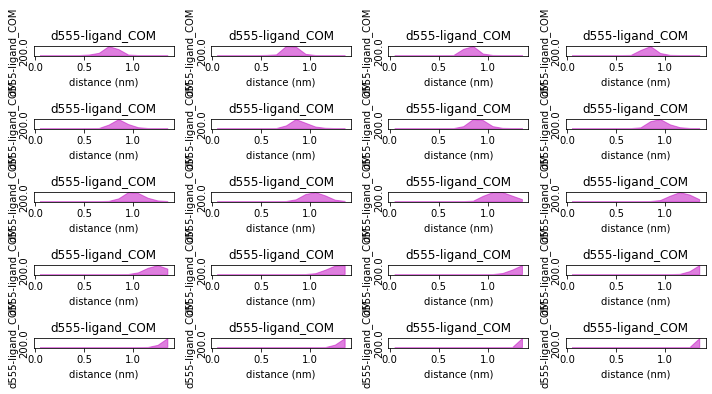

In [15]:
# For each RUN, lets look at the distrbution of the distances

from matplotlib import pyplot as plt
%matplotlib inline

# each input file has columns:
# clone	time(ns)	dist_7-116	dist_7-183	dist_7-208	dist_7-215
column_labels = ['clone', 'time(ns)', 'd555-ligand_COM']
colors = {'None':'k', 'd555-ligand_COM':'m'}
indir = '.'
plt.figure( figsize=(15,20) )
panel = 1
mybins = np.arange(0., 2.5, 0.1)
for i in range(K):
    run = run_indices[i]
    infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
    data = np.loadtxt(infile)
    for j in [2]:  # column indices for each distance
        counts, bin_edges = np.histogram(data[:,j], bins=mybins)
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
        plt.subplot(K,4,panel)
        plt.fill_between(bin_centers, counts, np.zeros(counts.shape), color=colors[restrained_distance_labels[i]], alpha=0.5)
        plt.xlabel('distance (nm)')
        plt.yticks([])
        plt.title(column_labels[j])
        if j==2:
            plt.ylabel(restrained_distance_labels[i]+'\n'+str(kspring_k[i]))
        panel += 1
plt.tight_layout()
plt.show()

## Step 2. Prepare the data for input to MBAR

### 2.1 subsample the data to remove time-correlations

MBAR (like other free energy estimators such as WHAM) assumes that samples are drawn from each thermodynamic ensemble at thermal equilibrium.  Any time-correlated data is *statistically inefficient* and will bias the results.  The authors of MBAR provide several tools in `pymbar.timeseries` to deal with this, which essentially compute the autocorrelation time $\tau_c$ of some observable, and subsample data every $2\tau_c$.  In theory, this is great, but in *practice*, this can sometimes pare down your samples much too sparsely.  If possible, I recommend using all the data, and then seeing how subsampling effects the results.  Of course, some datasets (especially from Folding@home) are simply too large to efficiently calculate free energies using MBAR. In this case, subsampling can be a huge help.

For now, we will **ignore** subsampling, and proceed with our (test) dataset.

### 2.2 construct the `u_kln` matrix of energies

The `pymbar.MBAR()` class expects data in one of two forms:

```
 |      ----------
 |      u_kn : np.ndarray, float, shape=(K, N_max)
 |          ``u_kn[k,n]`` is the reduced potential energy of uncorrelated
 |          configuration n evaluated at state k.
 |      u_kln : np.ndarray, float, shape (K, L, N_max)
 |          if the simulation is in form ``u_kln[k,l,n]`` it is converted to ``u_kn`` format
 |      
 |          u_kn = [ u_1(x_1) u_1(x_2) u_1(x_3) . . . u_1(x_n)
 |                   u_2(x_1) u_2(x_2) u_2(x_3) . . . u_2(x_n)
 |                                              . . .
 |                   u_k(x_1) u_k(x_2) u_k(x_3) . . . u_k(x_n)]
 |      
 |      N_k :  np.ndarray, int, shape=(K)
 |          ``N_k[k]`` is the number of uncorrelated snapshots sampled from state ``k``.
 |          Some may be zero, indicating that there are no samples from that state.
 |      
 |          We assume that the states are ordered such that the first ``N_k``
 |          are from the first state, the 2nd ``N_k`` the second state, and so
 |          forth. This only becomes important for BAR -- MBAR does not
 |          care which samples are from which state.  We should eventually
 |          allow this assumption to be overwritten by parameters passed
 |          from above, once ``u_kln`` is phased out.

```

For now, let's try to build an array of reduced energies in the `u_kln` form...

In [16]:
# First let's compute the lengths of all the trajectories

# N_k is the number of trajectory snapshots sampled in each enesmble 
N_k = np.zeros([K], dtype = int)   # make an empty array for now
for i in range(K):
    run = run_indices[i]
    infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
    N_k[i] = np.loadtxt(infile).shape[0]
print('N_k', N_k)
N_max = np.max(N_k)
print('N_max', N_max)

N_k [348447 325059 364060 370508 355192 360868 353925 348438 352087 339343
 345183 339457 345198 347181 314420 357070 346132 360325 338111 320721]
N_max 370508


In [17]:
# Next, we will create and fill the array u_kln
# u_kln[k,l,n] is the reduced potential energy of 
# snapshot n from umbrella simulation k evaluated at umbrella l
u_kln = np.zeros([K,L,N_max], np.float64) 

# Let's also keep track of all the reduced energies as calculated for the unbiased ensemble (k=0)
N_tot = N_k.sum()
u_n = np.zeros(N_tot)
u_n_fill_indices = [0] 
for k in range(K):
    u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])
print('len(u_n_fill_indices)', len(u_n_fill_indices))
print('u_n_fill_indices', u_n_fill_indices)
print('len(u_n)', len(u_n))

    

len(u_n_fill_indices) 21
u_n_fill_indices [0, 348447, 673506, 1037566, 1408074, 1763266, 2124134, 2478059, 2826497, 3178584, 3517927, 3863110, 4202567, 4547765, 4894946, 5209366, 5566436, 5912568, 6272893, 6611004, 6931725]
len(u_n) 6931725


In [18]:
for k in range(K):
    
    print('Calculating reduced potentials for ensemble', k, '...')
    run = run_indices[k]
    infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
    distances = np.loadtxt(infile)
    
    # calculate the value of the restraint potential for this (kth) ensemble
    
    if restrained_distance_labels[k] == 'None':
        use_column = None
    elif restrained_distance_labels[k] == 'd555-ligand_COM':
        use_column = 2
    
    if use_column == None:
        reduced_potential_for_k = np.zeros(N_k[k])
    else:
        reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(distances[:,use_column])**2
        
    for l in range(L):
        
        if restrained_distance_labels[l] == 'None':
            use_column = None
        elif restrained_distance_labels[l] == 'd555-ligand_COM':
            use_column = 2

        if use_column == None:
            reduced_potential_for_l = np.zeros(N_k[k])
        else:
            reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(distances[:,use_column])**2
        print(reduced_potential_for_k,reduced_potential_for_l)
        u_kln[k,l,0:N_k[k]] = reduced_potential_for_l - reduced_potential_for_k
        
        ## store energies u_n for the unbiased ensemble
        if l == 0:
            print('u_n_fill_indices[k],u_n_fill_indices[k+1]', u_n_fill_indices[k],u_n_fill_indices[k+1])
            u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = reduced_potential_for_l - reduced_potential_for_k

print('u_kln', u_kln)
print('u_n', u_n)



Calculating reduced potentials for ensemble 0 ...
[204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417] [204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417]
u_n_fill_indices[k],u_n_fill_indices[k+1] 0 348447
[204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417] [204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417]
[204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417] [204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417]
[204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417] [204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417]
[204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417] [204.92049302  77.48376492  71.97781138 ...  18.72684256  14.58981678
  12.70144417]
[204.92049302  77.48376492  71.97781138 ...  18.7

[204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ] [204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ]
u_n_fill_indices[k],u_n_fill_indices[k+1] 1037566 1408074
[204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ] [204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ]
[204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ] [204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ]
[204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ] [204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ]
[204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ] [204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ]
[204.92049302  87.5693144   73.71566235 ...  26.01004959  26.57848681
  28.747791  ] [204.92

[204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035] [204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035]
u_n_fill_indices[k],u_n_fill_indices[k+1] 2124134 2478059
[204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035] [204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035]
[204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035] [204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035]
[204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035] [204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035]
[204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035] [204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035]
[204.92049302 136.80024692 107.35453293 ...  28.73346804  29.61218381
  27.30424035] [204.92

[204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081] [204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081]
u_n_fill_indices[k],u_n_fill_indices[k+1] 3178584 3517927
[204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081] [204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081]
[204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081] [204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081]
[204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081] [204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081]
[204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081] [204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081]
[204.92049302 143.15584896 109.40640286 ...  34.29387123  33.49157213
  36.81542081] [204.92

[204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085] [204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085]
u_n_fill_indices[k],u_n_fill_indices[k+1] 4202567 4547765
[204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085] [204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085]
[204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085] [204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085]
[204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085] [204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085]
[204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085] [204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085]
[204.92049302 159.77828245 124.90303556 ...  48.03532519  42.92041086
  45.51801085] [204.92

[204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857] [204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857]
u_n_fill_indices[k],u_n_fill_indices[k+1] 5209366 5566436
[204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857] [204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857]
[204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857] [204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857]
[204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857] [204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857]
[204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857] [204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857]
[204.92049302 197.98066295 157.53078964 ... 112.37830008 113.1960232
 109.85676857] [204.92049302 197.

[204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844] [204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844]
u_n_fill_indices[k],u_n_fill_indices[k+1] 6272893 6611004
[204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844] [204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844]
[204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844] [204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844]
[204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844] [204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844]
[204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844] [204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844]
[204.92049302 170.18776476 142.70322848 ... 112.58282241 108.68618416
 115.89668844] [204.92

In [54]:
## Instantiate the MBAR object
print("Running MBAR...")
mbar = MBAR(u_kln, N_k, verbose = True)

Running MBAR...
K (total states) = 10, total samples = 103299

They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their

Final dimensionless free energies
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
MBAR initialization complete.


In [55]:
pmf_columns = [2,3,4,5]
for p in pmf_columns:
    
    print('Computing PMF for distance', column_labels[p])
    
    # bin the data up into distance bins
    nbins = 20
    dmin, dmax = 0.4, 6.0  # in nm
    dwidth = (dmax-dmin)/nbins
    distance_bins = np.arange(dmin, dmax+dwidth, dwidth)
    bin_centers = (distance_bins[0:-1]+distance_bins[1:])/2.0

    bin_n = np.zeros(N_tot)
    for k in range(K):
        run = run_indices[k]
        infile = os.path.join(os.path.abspath(indir),'run_%d_dists.dat'%run)
        data = np.loadtxt(infile)[:,p]
        bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = np.digitize(data, distance_bins, right=False)

    print('bin_n', bin_n)
    
    # Compute PMF in unbiased potential (in units of kT).
    results = mbar.computePMF(u_n, bin_n, nbins)
    f_i = results[0]
    df_i = results[1]

    # Write out PMF
    print("PMF (in units of kT)")
    print("%8s %8s %8s" % ('bin', 'f', 'df'))
    for i in range(nbins):
        print("%8.1f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i]))


Computing PMF for distance d566-1421
bin_n [1. 1. 1. ... 1. 1. 1.]


ParameterError: At least one bin in provided bin_n argument has no samples.  All bins must have samples for free energies to be finite.  Adjust bin sizes or eliminate empty bins to ensure at least one sample per bin.

In [72]:
dist_all=[]
for a in range(len(A)):
    print a
    #print "loading new_run_%d_dist.npy"%A[a]
    dists=np.load('new_dists/new_run_%d_dist_7-116.npy'%A[a])
    dist_all.append(dists)
print len(dist_all[0])

0
1
2
3
42649


In [ ]:
dist_min = 0.0 # min for PMF
dist_max = 7.0 # max for PMF  

In [75]:
# Construct bins
nbins=3
print("Binning data...")
delta = (dist_max - dist_min) / float(nbins)
print delta
# compute bin centers
bin_center_i = numpy.zeros([nbins], numpy.float64)
for i in range(nbins):
    bin_center_i[i] = dist_min + delta/2 + delta * i
print bin_center_i
# Bin data

bins_all=[]
for i in range(len(dist_all)):
        # Compute bin assignment.
        bins=[]
        for j in range(len(dist_all[i])):
            bin  = int((dist_all[i][j] - dist_min) / delta)
            bins.append(bin)
        bins_all.append(bins)
print bins_all

Binning data...
2.33333333333
[ 1.16666667  3.5         5.83333333]
[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [76]:
# Compute PMF for these unequally-sized bins.
results = mbar.computePMF(U, bins_all, nbins)
f_i = results[0]
df_i = results[1]

# Write out PMF
print("PMF (in units of kT)")
print("%8s %8s %8s" % ('bin', 'f', 'df'))
fout = open('WT_mbar_%dK_7-116.dat'%temperature,'w')                              ########changing the saving name
fout.write('# distance (nm)\tf (kT)\tdf (kT)\n')
for i in range(nbins):
    #print i
    fout.write("%8.1f\t%8.3f\t%8.3f\n" % (bin_center_i[i], f_i[i], df_i[i]))
    print("%8.1f %8.3f %8.3f" % (bin_center_i[i], f_i[i], df_i[i]))
fout.close()
print 'Wrote'

ParameterError: At least one bin in provided bin_n argument has no samples.  All bins must have samples for free energies to be finite.  Adjust bin sizes or eliminate empty bins to ensure at least one sample per bin.

No handlers could be found for logger "matplotlib.legend"


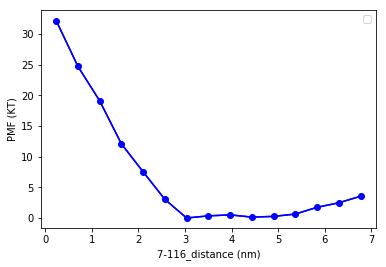

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(bin_center_i, f_i,"o-", c='b')
plt.errorbar(bin_center_i, f_i, yerr=df_i, c='b')
plt.xlabel('7-116_distance (nm)')
plt.ylabel('PMF (KT)')
plt.legend()
plt.show()